# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Import Packages

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

In [ ]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224,224,3), weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


# Varying Length

## Small sample size: model run (5%) 86.61% test, 92.51% train



In [ ]:
train_data_dir = "/content/drive/My Drive/Data/unique_5_sample_train"
test_data_dir = "/content/drive/My Drive/Data/unique_5_sample_test"

In [ ]:
path = train_data_dir
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 300 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
x = Flatten()(model.output)
# x = tf.keras.layers.Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model1 = Model(inputs=model.input, outputs=output)

In [ ]:
model1.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [ ]:
history1 = model1.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
38/38 [==============================] - 206s 5s/step - loss: 1.7523 - accuracy: 0.7467 - val_loss: 1.8874 - val_accuracy: 0.9032
Epoch 2/20
38/38 [==============================] - 10s 268ms/step - loss: 0.3430 - accuracy: 0.9133 - val_loss: 0.4586 - val_accuracy: 0.9194
Epoch 3/20
38/38 [==============================] - 10s 269ms/step - loss: 0.0643 - accuracy: 0.9767 - val_loss: 0.9822 - val_accuracy: 0.9194
Epoch 4/20
38/38 [==============================] - 10s 270ms/step - loss: 0.0595 - accuracy: 0.9700 - val_loss: 0.6261 - val_accuracy: 0.9194
Epoch 5/20
38/38 [==============================] - 10s 264ms/step - loss: 0.0397 - accuracy: 0.9867 - val_loss: 0.2463 - val_accuracy: 0.9677
Epoch 6/20
38/38 [==============================] - 10s 263ms/step - loss: 5.6644e-04 - accuracy: 1.0000 - val_loss: 0.1850 - val_accuracy: 0.9839
Epoch 7/20
38/38 [==============================] - 10s 262ms/step - loss: 1.1269e-04 - accuracy: 1.0000 - val_loss: 0.1620 - val_accuracy: 

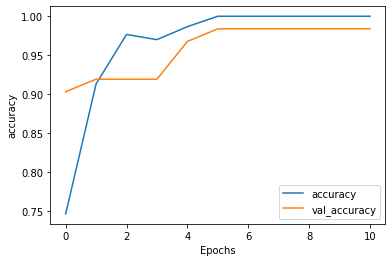

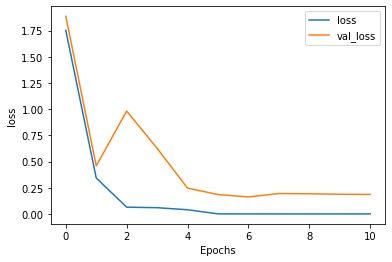

In [ ]:
plotting(history1, "accuracy")
plotting(history1, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

62/62 [==============================] - 2s 35ms/step - loss: 0.1858 - accuracy: 0.9839
Test Accuracy: 98.39%
38/38 [==============================] - 8s 211ms/step - loss: 1.2964e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


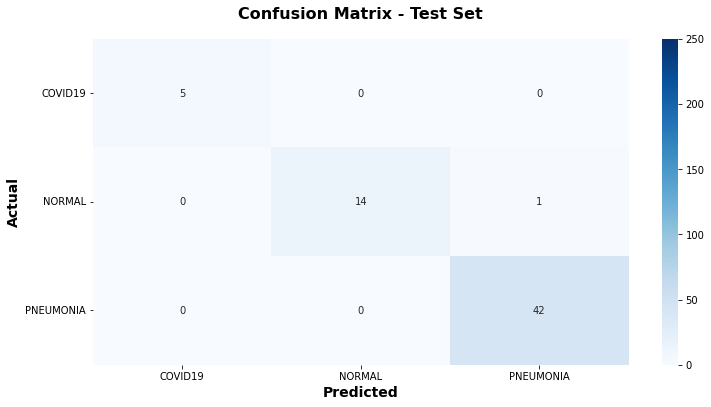

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## Model run 2

## Small sample size: model run (20%) 93% test, 100% train

In [ ]:
train_data_dir = "/content/drive/My Drive/Data/unique_20_sample_train"
test_data_dir = "/content/drive/My Drive/Data/unique_20_sample_test"

In [ ]:
path = train_data_dir
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
x = Flatten()(model.output)
# x = tf.keras.layers.Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model2 = Model(inputs=model.input, outputs=output)

In [ ]:
model2.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)

In [ ]:
history2 = model2.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
151/151 [==============================] - 783s 5s/step - loss: 0.8354 - accuracy: 0.8456 - val_loss: 2.9025 - val_accuracy: 0.8016
Epoch 2/20
151/151 [==============================] - 40s 267ms/step - loss: 0.1588 - accuracy: 0.9461 - val_loss: 0.7945 - val_accuracy: 0.9222
Epoch 3/20
151/151 [==============================] - 40s 266ms/step - loss: 0.1141 - accuracy: 0.9544 - val_loss: 0.9177 - val_accuracy: 0.9339
Epoch 4/20
151/151 [==============================] - 41s 269ms/step - loss: 0.0727 - accuracy: 0.9734 - val_loss: 0.9839 - val_accuracy: 0.9183
Epoch 5/20
151/151 [==============================] - 40s 268ms/step - loss: 0.0625 - accuracy: 0.9751 - val_loss: 1.5566 - val_accuracy: 0.9144
Epoch 6/20
151/151 [==============================] - 40s 266ms/step - loss: 0.0621 - accuracy: 0.9701 - val_loss: 1.0807 - val_accuracy: 0.9222
Epoch 7/20
151/151 [==============================] - 40s 266ms/step - loss: 0.0222 - accuracy: 0.9884 - val_loss: 0.8997 - val_accu

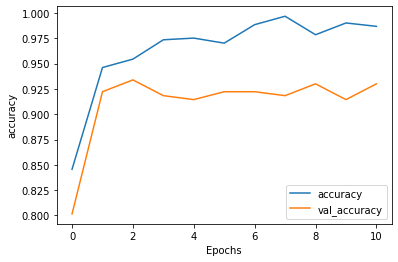

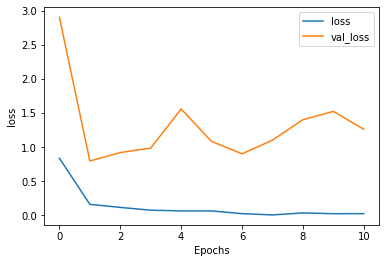

In [ ]:
plotting(history2, "accuracy")
plotting(history2, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model2.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model2.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

257/257 [==============================] - 9s 35ms/step - loss: 1.2589 - accuracy: 0.9300
Test Accuracy: 93.00%
151/151 [==============================] - 31s 207ms/step - loss: 6.9696e-04 - accuracy: 1.0000
Train Accuracy: 100.00%


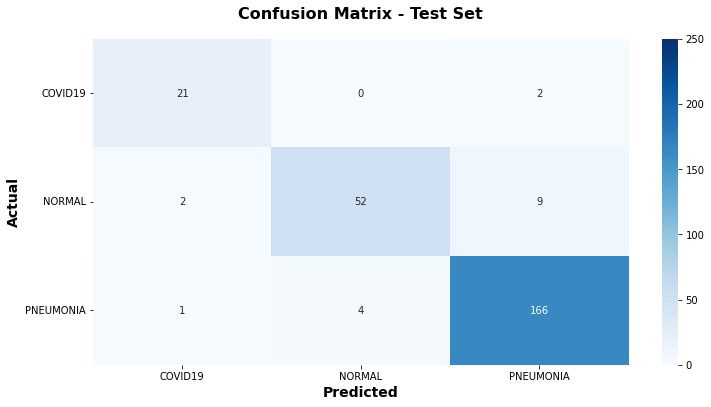

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model2.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## Model run 3


## Small sample size: model run (60%) 95.34% test, 99.97% train

In [ ]:
train_data_dir = "/content/drive/My Drive/Data/unique_60_sample_train"
test_data_dir = "/content/drive/My Drive/Data/unique_60_sample_test"


In [ ]:
path = train_data_dir
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 3618 images belonging to 3 classes.
Found 772 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
x = Flatten()(model.output)
# x = tf.keras.layers.Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model3 = Model(inputs=model.input, outputs=output)

In [ ]:
model3.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)

In [ ]:
history3 = model3.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
453/453 [==============================] - 987s 2s/step - loss: 0.4141 - accuracy: 0.8991 - val_loss: 0.4957 - val_accuracy: 0.9119
Epoch 2/20
453/453 [==============================] - 130s 287ms/step - loss: 0.0840 - accuracy: 0.9444 - val_loss: 0.3467 - val_accuracy: 0.9560
Epoch 3/20
453/453 [==============================] - 131s 288ms/step - loss: 0.0644 - accuracy: 0.9502 - val_loss: 0.2080 - val_accuracy: 0.9417
Epoch 4/20
453/453 [==============================] - 131s 289ms/step - loss: 0.0261 - accuracy: 0.9754 - val_loss: 0.3851 - val_accuracy: 0.9404
Epoch 5/20
453/453 [==============================] - 130s 288ms/step - loss: 0.0169 - accuracy: 0.9815 - val_loss: 0.2152 - val_accuracy: 0.9598
Epoch 6/20
453/453 [==============================] - 131s 289ms/step - loss: 0.0382 - accuracy: 0.9729 - val_loss: 0.2165 - val_accuracy: 0.9534
Epoch 7/20
453/453 [==============================] - 130s 288ms/step - loss: 0.0163 - accuracy: 0.9873 - val_loss: 0.2055 - va

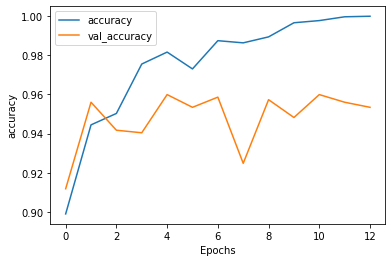

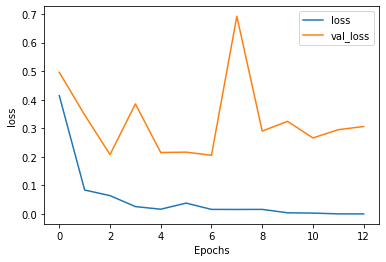

In [ ]:
plotting(history3, "accuracy")
plotting(history3, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

772/772 [==============================] - 27s 35ms/step - loss: 0.3062 - accuracy: 0.9534
Test Accuracy: 95.34%
453/453 [==============================] - 97s 215ms/step - loss: 9.0461e-04 - accuracy: 0.9997
Train Accuracy: 99.97%


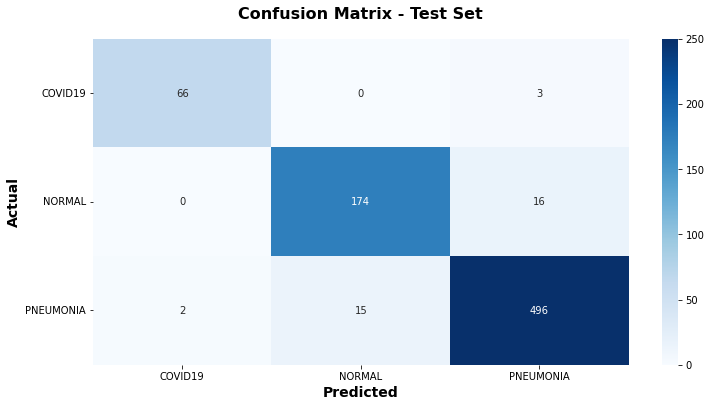

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model3.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);